In [ ]:
pip install yfinance

In [ ]:
pip install livelossplot

In [ ]:
import numpy as np                  # Работа с векторами, матрицами, тензорами
import yfinance as yf               # YahooFinance
import pandas as pd                 # Работа с фреймами данных
import matplotlib.pyplot as plt     # Отрисовка графиков

Функция загрузки данных в python из yahoo.finance

In [ ]:
def download_yahoo_data(symbols_array, start, end, column = 'Close'):
    """
    download_yahoo_data downloads data from yahoo.finance.com by 
    symbols from symbols_array

    :param symbols_array: determines an array of symbols to download from yahoo
    :param start: a date in format "YYYY-MM-DD" to mark the start date to download
    :param end: a date in format "YYYY-MM-DD" to mark the end date to download
    :param column: a string parameter from array of ["Close", "Adj.Close", "Open", "High", "low"]
    :return: list of time series and list of downloaded symbols
    """ 
    
    # Уникальные значения символов
    symbols_array = list(set(symbols_array))
    
    # Загрузка данных
    data_frame = pd.DataFrame()         # Данные временных рядов
    for i in range(len(symbols_array)):
        # Загрузка по одному ряду по массиву символов
        ts = yf.download(symbols_array[i], 
                         start = start, 
                         end = end, 
                         progress = False)
        
        if (i == 0):
            data_frame["Date"] = ts.index
              
        data_frame[str(symbols_array[i])] = np.array(ts[column])        # Складируем
        # print(symbols_array[i] + " downloaded!")
    return data_frame, symbols_array

Функция исключения линейного тренда из ряда данных и последующего нормирования данных

Нормирование временного ряда

In [ ]:
def scale_ts(ts):
    # Среднее данных
    mean_ts_out = np.mean(ts)

    # Наибольшее и наименьшее в данных
    y_max = np.max(ts)
    y_min = np.min(ts)

    # Нормализованный ряд
    norm_ts = (ts - y_min)/(y_max - y_min)

    return norm_ts, mean_ts_out, y_max, y_min

def scaler_with_inputs(ts, y_min, y_max):
    return (ts - y_min) / (y_max - y_min)

def unscaler(ts, y_min, y_max):
    return ts * (y_max - y_min) + y_min

Загрузка дат для тренировки, теста и прогноза

In [ ]:
# Дней вперёд хотим прогнозировать
future_pred = 30            

# Дней месяцев и лет берём для теста
days_test = 10
months_test = 0
years_test = 0

# Дней от сегодня для начала train ряда
days_train = 220
months_train = 0
years_train = 0

# Подгружаемые акции
symbols_array = ['FB', 'GSHD', '^IXIC', 'MVIS', 'LUKOY', 'GME', 'NIO', 'BNO', 
                 'GSX', 'YVR', 'GM', 'CYDY', 'ATVI', 'F', 'HLNE', 'IIIV', 
                 '^VIX', 'AAPL', 'MSFT', 'PCG', 'MU', 'HAS', 'FOCS', 'GNUS', 
                 'KO', '^DJI', 'TSLA', 'EVOP', 'NNOX', 'QQQ', 'NVAX', 'MARA', 
                 'AMD', 'PLMR', 'MP', 'ACAD', 'PEP', 'DLPN', '^GSPC', 
                 'NKE', 'GOOG', '^RUT', 'TWTR']

# Количество членов авторегрессии
tw = 14

In [ ]:
from datetime import datetime
import dateutil.relativedelta

# Дата сегодня
dateToday = datetime.today()
print("Date today: " + dateToday.strftime('%Y-%m-%d'))

# Дата месяц назад
dateMonthAgo = datetime.today() - dateutil.relativedelta.relativedelta(days = days_test, 
                                                                       months = months_test, 
                                                                       years = years_test)
print("One month before today: " + dateMonthAgo.strftime('%Y-%m-%d'))

# Дата месяцы назад
dateMonthsAgo = datetime.today() - dateutil.relativedelta.relativedelta(days = days_train, months = months_train, years = years_train)
print("Six months before today: " + dateMonthsAgo.strftime('%Y-%m-%d'))

# Дата на прогноз
dateFuturePred = datetime.today() + dateutil.relativedelta.relativedelta(days = future_pred)
print("Date in future: " + dateFuturePred.strftime('%Y-%m-%d'))

Date today: 2021-04-19
One month before today: 2021-04-09
Six months before today: 2020-09-11
Date in future: 2021-05-19


Загрузка данных рядов

In [ ]:
ts_df, _ = download_yahoo_data(symbols_array = symbols_array, 
                                     start = dateMonthsAgo, 
                                     end = dateToday, 
                                     column = 'Close')

ts_df_train = ts_df[:(len(ts_df) - days_test)]
ts_df_test = ts_df[(len(ts_df) - days_test - tw):]

## **Построение модели нейронной сети для прогнозирования одного ряда данных**

Нейронная сеть будет иметь следующую архитектуру:

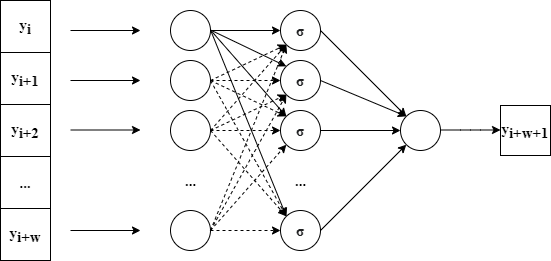

In [ ]:
import torch
from torch import nn

In [ ]:
class reluLayerNet(nn.Module):
    def __init__(self, input_size, hidden_layer_size, output_size=1, p = 0.15):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_layer_size)
        self.activ1 = nn.ReLU()
        self.out = nn.Linear(hidden_layer_size, output_size)

        self.dropout = nn.Dropout(p = p)

    def forward(self, data):
        x = self.fc1(data)
        x = self.dropout(x)
        x = self.activ1(x)
        x = self.out(x)
        return x
    
    def predict(self, data):
        x = self.fc1(data)
        x = self.activ1(x)
        x = self.out(x)
        return x

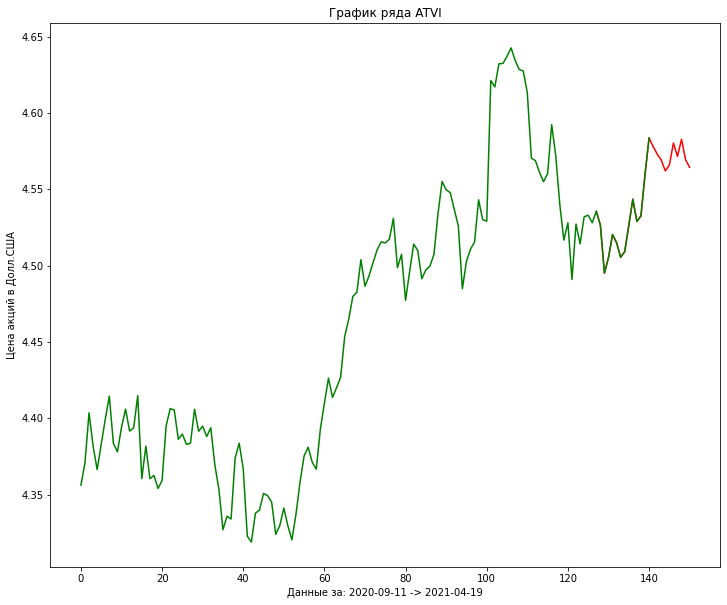

In [ ]:
# Номер отображаемого графика
num_ts_show = 12

plt.figure(figsize=(12, 10))
plt.title("График ряда " + str(symbols_array[num_ts_show]))
plt.xlabel("Данные за: " + dateMonthsAgo.strftime('%Y-%m-%d') + " -> " + dateToday.strftime('%Y-%m-%d'))
plt.ylabel("Цена акций в Долл.США")
plt.plot(ts_df_test[symbols_array[num_ts_show]].index, np.log(ts_df_test[symbols_array[num_ts_show]]), c = "r")
plt.plot(ts_df_train[symbols_array[num_ts_show]].index, np.log(ts_df_train[symbols_array[num_ts_show]]), c = "g")

In [ ]:
def fc_dataset(ts, time_window = 12):
    X = []
    y = []
    for window in range(time_window, len(ts)):
        X.append([ts[(window - time_window):window]])
        y.append([ts[window]])
    return X, y

In [ ]:
ts_logged = list(np.log(ts_df_train[symbols_array[num_ts_show]]))
ts_log_norm, mean_ts_out, y_max, y_min = scale_ts(ts_logged)

test_log = list(np.log(ts_df_test[symbols_array[num_ts_show]]))
test_log_norm = scaler_with_inputs(test_log, y_min, y_max)

train_x, train_y = fc_dataset(ts_log_norm, time_window = tw)
test_x, test_y = fc_dataset(test_log_norm, time_window = tw)

train_x = torch.FloatTensor(train_x)
train_y = torch.FloatTensor(train_y)
test_x = torch.FloatTensor(test_x)
test_y = torch.FloatTensor(test_y)

In [ ]:
seed = 123

import random
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

In [ ]:
# Архитектура сети
input_size = tw   # Количество входных нейронов
hidden_layer_size = tw           # Количество нейронов в скрытом слое
output_size = 1                 # Количество выходных нейронов

# Полносвязная нейронная сеть
model_fc = reluLayerNet(input_size, hidden_layer_size, output_size)
# Средний квадрат ошибок как функция потерь
loss_function = nn.MSELoss()
# Метод оптимизации - Адам, скорость обучения 0.001
optimizer = torch.optim.Adam(model_fc.parameters(), lr = 0.002)

In [ ]:
from livelossplot import PlotLosses
def train_with_validation(model, optimizer, loss_function, train_x, train_y, test_x, test_y, 
                          batch_size = 1, epochs = 30, print_valid = True, plot_ticker = True):

    loss_train = []
    loss_test = []
    liveplot = PlotLosses()

    # Эпохи обучения
    for epoch in range(epochs):
        # Обучение сети -----------------------------------------------------
        # Переведём модель в обучение и занулим градиенты оптимизатора
        model.train()
        num_of_instances = train_x.shape[0]
        for idx in range(0, num_of_instances, batch_size):    
            optimizer.zero_grad()

            X_batch = train_x[idx:min((idx+batch_size), num_of_instances)]
            y_batch = train_y[idx:min((idx+batch_size), num_of_instances)]
            # Найдём ответы сети на данных и найдём ошибки
            y_pred = model.forward(X_batch)
            loss_tr = loss_function(y_pred, y_batch)

            # Произведём просчёт всех градиентов в тензорах весов сети
            loss_tr.backward()

            # Шаг оптимизатора
            optimizer.step()

            
        # Сохраним результат последнего лосса
        loss_train.append(loss_tr.item())

        # Валидация сети -----------------------------------------------------
        # Перевод модели в режим валидации (не считаются градиенты)
        model.eval()

        # Подсчитаем предсказания и loss по ответам сети, сохраним loss
        y_pred_eval = model.forward(test_x)
        loss_te = loss_function(y_pred_eval, test_y)
        loss_test.append(loss_te.item())
    
        if (epoch % 50 == 0 and print_valid):
            print("Эпоха номер " + str(epoch))
            print("loss на тренировке: " + str(loss_tr.item()))
            print("loss на валидации: " + str(loss_te.item()))
            print(" ")
        if (epoch % 10 == 0 and plot_ticker):
            liveplot.update({'train':loss_tr.item(), 'validation':loss_te.item()})
            liveplot.send()
    return model, loss_test[len(loss_test) - 1], loss_train, loss_test

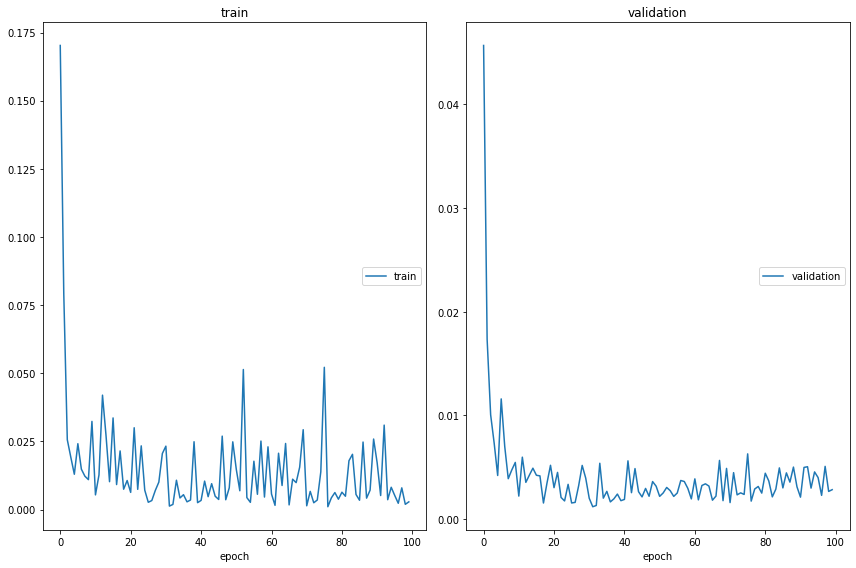

train
	train            	 (min:    0.001, max:    0.170, cur:    0.003)
validation
	validation       	 (min:    0.001, max:    0.046, cur:    0.003)


In [ ]:
model_fc, val_score, _, _ = train_with_validation(model_fc, optimizer, loss_function, train_x, train_y, test_x, test_y, epochs=1000, print_valid=True, plot_ticker=True, batch_size=1)

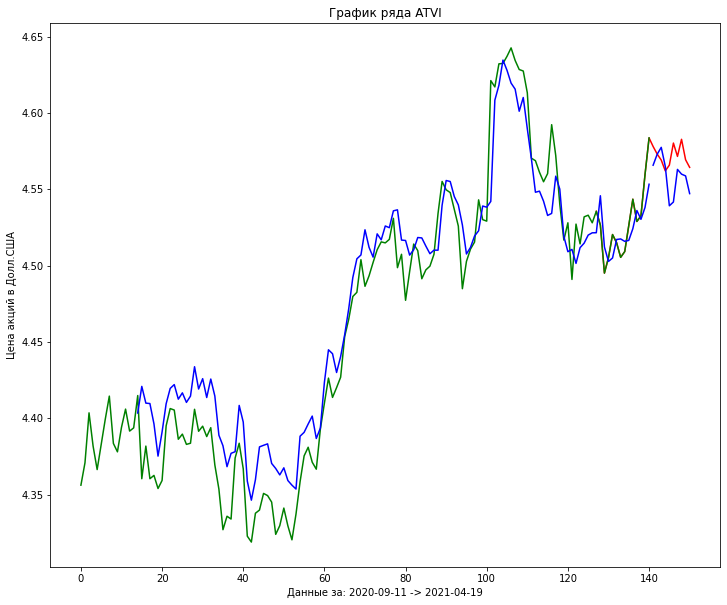

In [ ]:
model_fc.eval()
plt.figure(figsize=(12, 10))
plt.title("График ряда " + str(symbols_array[num_ts_show]))
plt.xlabel("Данные за: " + dateMonthsAgo.strftime('%Y-%m-%d') + " -> " + dateToday.strftime('%Y-%m-%d'))
plt.ylabel("Цена акций в Долл.США")
plt.plot(ts_df_test[symbols_array[num_ts_show]].index, np.log(ts_df_test[symbols_array[num_ts_show]]), c = "r")
plt.plot(ts_df_train[symbols_array[num_ts_show]].index, np.log(ts_df_train[symbols_array[num_ts_show]]), c = "g")
predictions_val = unscaler(model_fc.predict(test_x).detach(), y_min, y_max)
plt.plot(range(ts_df_test.index.stop - days_test, ts_df_test.index.stop), list(predictions_val), c = "b")
fits = unscaler(model_fc.predict(train_x).detach(), y_min, y_max)
plt.plot(range(tw, len(fits) + tw), list(fits), c = "b")

In [ ]:
def train_without_validation(model, optimizer, loss_function,
                             train_x, train_y, epochs = 300, 
                             print_valid = False, batch_size = 1):

    loss_train = []
    # Эпохи обучения
    for epoch in range(epochs):
        # Обучение сети -----------------------------------------------------
        # Переведём модель в обучение и занулим градиенты оптимизатора
        model.train()
        num_of_instances = train_x.shape[0]
        for idx in range(0, num_of_instances, batch_size):    
            optimizer.zero_grad()

            X_batch = train_x[idx:min((idx+batch_size), num_of_instances)]
            y_batch = train_y[idx:min((idx+batch_size), num_of_instances)]
            # Найдём ответы сети на данных и найдём ошибки
            y_pred = model.forward(X_batch)
            loss_tr = loss_function(y_pred, y_batch)

            # Произведём просчёт всех градиентов в тензорах весов сети
            loss_tr.backward()

            # Шаг оптимизатора
            optimizer.step()

            
        # Сохраним результат последнего лосса
        loss_train.append(loss_tr.item())

        if (epoch % 50 == 0 and print_valid):
            print("Эпоха номер " + str(epoch))
            print("loss на тренировке: " + str(loss_tr.item()))
            print(" ")
    return model, loss_train

In [ ]:
ts_log = list(np.log(ts_df[symbols_array[num_ts_show]]))
ts_log_norm, mean_ts_out, y_max, y_min = scale_ts(ts_log)
train_x, train_y = fc_dataset(ts_log_norm, time_window = tw)

train_x = torch.FloatTensor(train_x)
train_y = torch.FloatTensor(train_y)

In [ ]:
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

In [ ]:
# Архитектура сети
input_size = tw   # Количество входных нейронов
hidden_layer_size = tw           # Количество нейронов в скрытом слое
output_size = 1                 # Количество выходных нейронов

# Полносвязная нейронная сеть
model_fc2 = reluLayerNet(input_size, hidden_layer_size, output_size)
# Средний квадрат ошибок как функция потерь
loss_function = nn.MSELoss()
# Метод оптимизации - Адам, скорость обучения 0.001
optimizer = torch.optim.Adam(model_fc2.parameters(), lr = 0.002)

In [ ]:
model_fc2, _ = train_without_validation(model_fc2, optimizer, loss_function,
                             train_x, train_y, epochs = 1000, batch_size = 1)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Predict loop

In [ ]:
# TODO:
# Implement prediction loop
def prediction_loop(model, ts, time_window, future_predict):
    len_ts = len(ts)
    last_ind = (len_ts-1)
    ts = torch.FloatTensor(ts)
    model.eval()
    for pred in range(future_predict):
        ts_sub = ts[(len_ts - time_window + pred):(len_ts + pred)]
        y_pred = model.predict(ts_sub)
        ts = torch.cat((ts, y_pred))
    df_pred = pd.DataFrame(index = range(last_ind + 1, last_ind + 1 + future_predict))
    df_pred['Prediction'] = np.array(ts[len_ts:(len_ts + future_predict)].detach())
    return df_pred

In [ ]:
prediction_ts = prediction_loop(model = model_fc2, 
                                ts = ts_log_norm,
                                time_window = tw,
                                future_predict = future_pred)

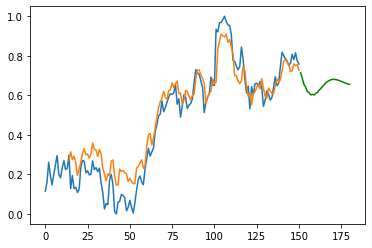

In [ ]:
shift = tw
model_fc2.eval()
plt.plot(ts_log_norm)
plt.plot(range(len(ts_log_norm), len(ts_log_norm) + future_pred), list(prediction_ts['Prediction']), c = "g")
plt.plot(range(shift, len(ts_log_norm) - tw + shift), list(model_fc2.predict(train_x).detach()))

In [ ]:
prediction_ts = unscaler(prediction_ts['Prediction'], y_min, y_max)

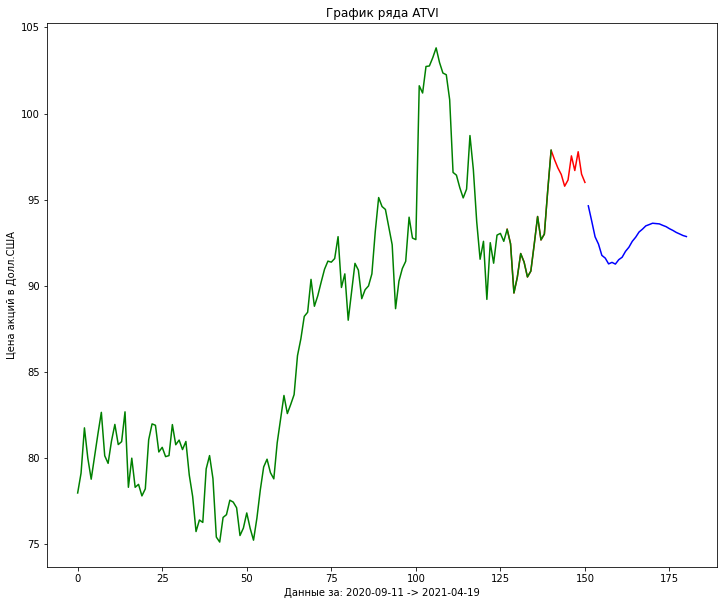

In [ ]:
plt.figure(figsize=(12, 10))
plt.title("График ряда " + str(symbols_array[num_ts_show]))
plt.xlabel("Данные за: " + dateMonthsAgo.strftime('%Y-%m-%d') + " -> " + dateToday.strftime('%Y-%m-%d'))
plt.ylabel("Цена акций в Долл.США")
plt.plot(ts_df_test[symbols_array[num_ts_show]].index, ts_df_test[symbols_array[num_ts_show]], c = "r")
plt.plot(ts_df_train[symbols_array[num_ts_show]].index, ts_df_train[symbols_array[num_ts_show]], c = "g")
plt.plot(prediction_ts.index, np.exp(prediction_ts), c = 'b')

In [ ]:
torch.save(model_fc2, "Relu_model")